In [6]:
from os import path
import pickle

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# import h5py
from scipy.spatial import cKDTree
from scipy.special import logsumexp
from scipy.optimize import minimize

# from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.potential as gp
from gala.mpl_style import center_emph, center_deemph

import emcee


from matplotlib.patches import Ellipse
from astroML.plotting.tools import draw_ellipse
from astroML.utils import log_multivariate_gaussian

In [7]:
import vaex

In [8]:
from xdgmm import XDGMM

In [2]:
orig_g = GaiaData('../antlia2-gaiadr2.fits')
orig_g = orig_g[orig_g.parallax < 0.25*u.mas]

In [3]:
obj_c = coord.SkyCoord(ra=143.8868*u.deg, dec=-36.7673*u.deg,
                       distance=132*u.kpc)
obj_feh = -1.36

In [4]:
iso = Table.read('/Users/apricewhelan/data/Isochrones/MIST/FeH_-1.4_iso.fits')
iso = iso[iso['log10_isochrone_age_yr'] == 10.]
iso = iso[iso['phase'] < 3]

In [35]:
# G0 = orig_g.get_G0()
# BPRP = orig_g.get_BP0() - orig_g.get_RP0()
G0 = orig_g.phot_g_mean_mag
BPRP = orig_g.phot_bp_mean_mag - orig_g.phot_rp_mean_mag

BPRP_err = np.sqrt((1/orig_g.phot_bp_mean_flux_over_error)**2 + 
                   (1/orig_g.phot_rp_mean_flux_over_error)**2)
G_err = 1 / orig_g.phot_g_mean_flux_over_error
c = orig_g.get_skycoord(distance=False)

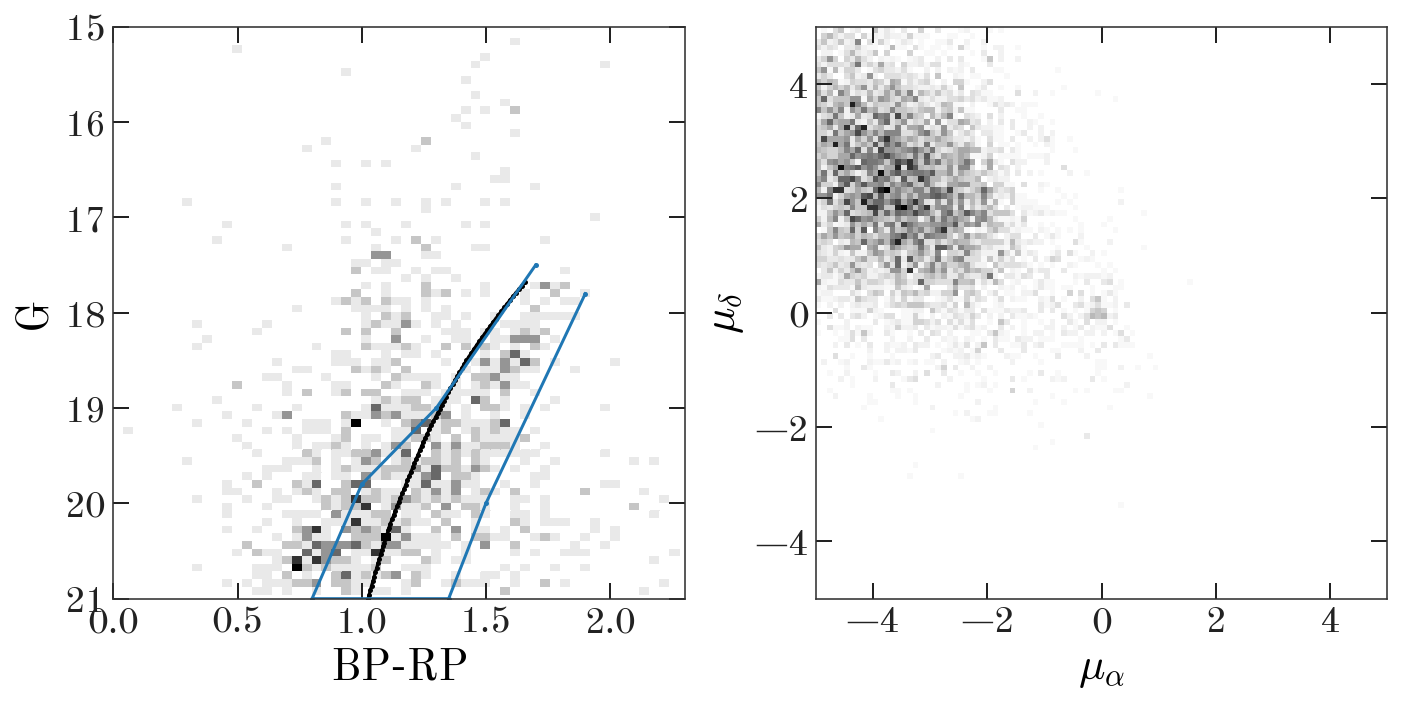

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
tmp_mask = ((c.separation(obj_c) < 1.5*u.deg) & 
            (np.sqrt(c.pm_ra_cosdec**2 + c.pm_dec**2) < 0.8*u.mas/u.yr))
ax.hist2d(BPRP[tmp_mask], G0[tmp_mask], 
          bins=(np.arange(0, 2.3+1e-3, 0.04),
                np.arange(14., 21+1e-3, 0.08)),
          cmap='Greys')

ax.plot(iso['G_BP'] - iso['G_RP'],
        iso['G'] + obj_c.distance.distmod.value)

# cmd_poly = np.array([[1.7, 17.5],
#                      [1.3, 19],
#                      [1., 19.8],
#                      [0.7, 20],
#                      [0.7, 21],
#                      [1.35, 21],
#                      [1.5, 20],
#                      [1.9, 17.8]])
cmd_poly = np.array([[1.7, 17.5],
                     [1.3, 19],
                     [1., 19.8],
                     [0.8, 21],
                     [1.35, 21],
                     [1.5, 20],
                     [1.9, 17.8]])
ax.plot(cmd_poly[:, 0], cmd_poly[:, 1])
path = mpl.path.Path(cmd_poly)

ax.set_xlim(0, 2.3)
ax.set_ylim(21, 15)

ax = axes[1]
tmp_mask = ((c.separation(obj_c) < 1.5*u.deg) & 
            path.contains_points(np.stack((BPRP.value, G0.value)).T))
ax.hist2d(orig_g.pmra[tmp_mask], orig_g.pmdec[tmp_mask],
          bins=np.arange(-5, 5.+1e-3, 0.1),
          cmap='Greys',
          vmin=2, vmax=20)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

axes[0].set_xlabel('BP-RP')
axes[0].set_ylabel('G')
axes[1].set_xlabel(r'$\mu_\alpha$')
axes[1].set_ylabel(r'$\mu_\delta$')

fig.tight_layout()

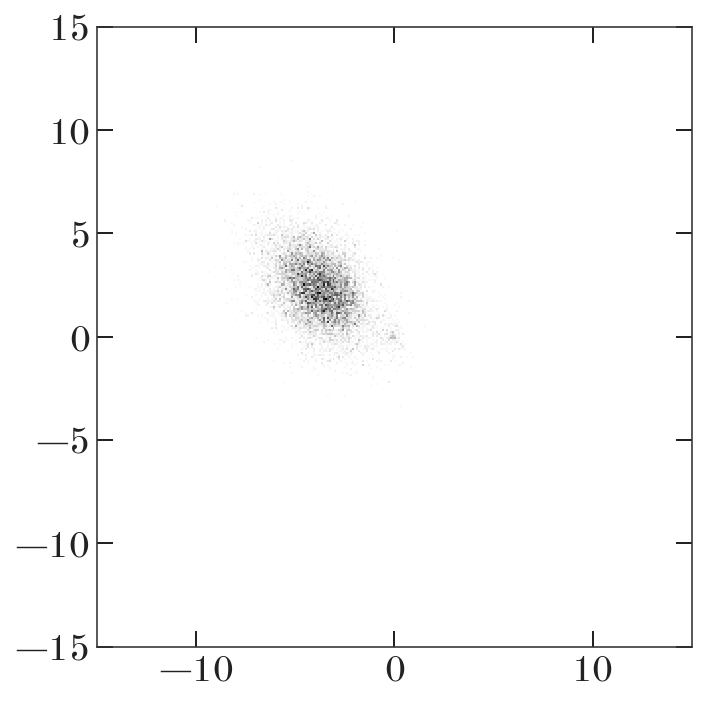

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))

tmp_mask = ((c.separation(obj_c) < 1.5*u.deg) & 
            path.contains_points(np.stack((BPRP.value, G0.value)).T))
ax.hist2d(orig_g.pmra[tmp_mask], orig_g.pmdec[tmp_mask],
          bins=np.arange(-15, 15.+1e-3, 0.1),
          cmap='Greys',
          vmin=2, vmax=20)
fig.tight_layout()

In [39]:
mask = ((c.separation(obj_c) < 1.*u.deg) & 
         path.contains_points(np.stack((BPRP.value, G0.value)).T))

In [40]:
ctl_mask = ((c.separation(obj_c) > 1.5*u.deg) & 
            path.contains_points(np.stack((BPRP.value, G0.value)).T))

In [41]:
X_co = np.vstack((orig_g.pmra.value, orig_g.pmdec.value)).T[ctl_mask]
X_cl = np.vstack((orig_g.pmra.value, orig_g.pmdec.value)).T[mask]

Cov_co = orig_g[ctl_mask].get_cov()[:, 3:5, 3:5]
Cov_cl = orig_g[mask].get_cov()[:, 3:5, 3:5]

In [42]:
X_cl.shape

(11207, 2)

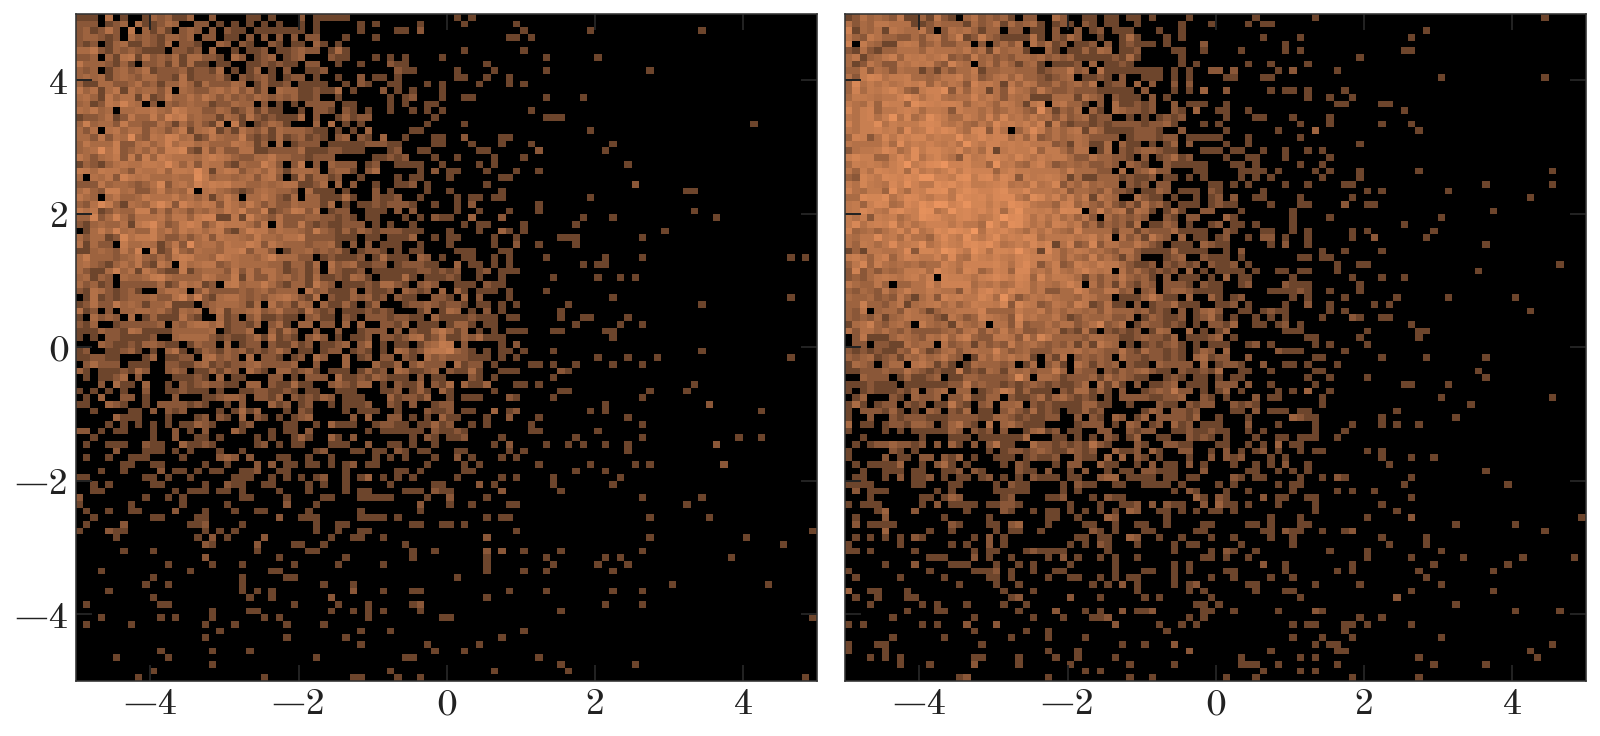

In [43]:
bins = np.arange(-5, 5+1e-3, 0.1)

H_cl, xe, ye = np.histogram2d(X_cl[:, 0], X_cl[:, 1],
                              bins=bins)

H_co, xe, ye = np.histogram2d(X_co[:, 0], X_co[:, 1],
                              bins=bins)

fig, axes = plt.subplots(1, 2, figsize=(11, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

ax = axes[0]
ax.pcolormesh(xe, ye, H_cl.T + 0.1, cmap='copper', 
              norm=mpl.colors.LogNorm(vmin=0.1, vmax=100))

ax = axes[1]
ax.pcolormesh(xe, ye, H_co.T + 0.1, cmap='copper',
              norm=mpl.colors.LogNorm(vmin=0.1, vmax=100))

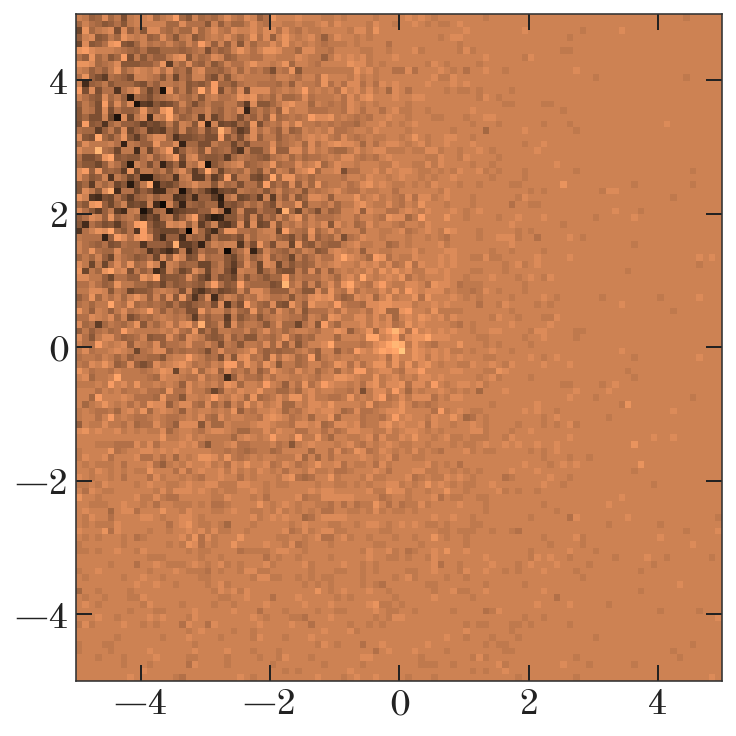

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), 
                       constrained_layout=True)
ax.pcolormesh(xe, ye, (H_cl - H_co).T, cmap='copper')

## Extreme deconvolution

First use heuristics to determine number of components:

In [45]:
# xdgmm = XDGMM(method='Bovy', n_iter=100)

# param_range = np.arange(1, 8+1, 1)

# # Loop over component numbers, fitting XDGMM model and computing the BIC:
# bic, optimal_n_comp, lowest_bic = xdgmm.bic_test(X_co, Cov_co, param_range)

# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.plot(param_range, bic, marker='', drawstyle='steps-mid')
optimal_n_comp = 5

In [46]:
gmm = XDGMM(n_components=optimal_n_comp, method='Bovy', 
            random_state=np.random.RandomState(42),
            n_iter=2048)
_ = gmm.fit(X_co, Cov_co)

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


(-20, 20)

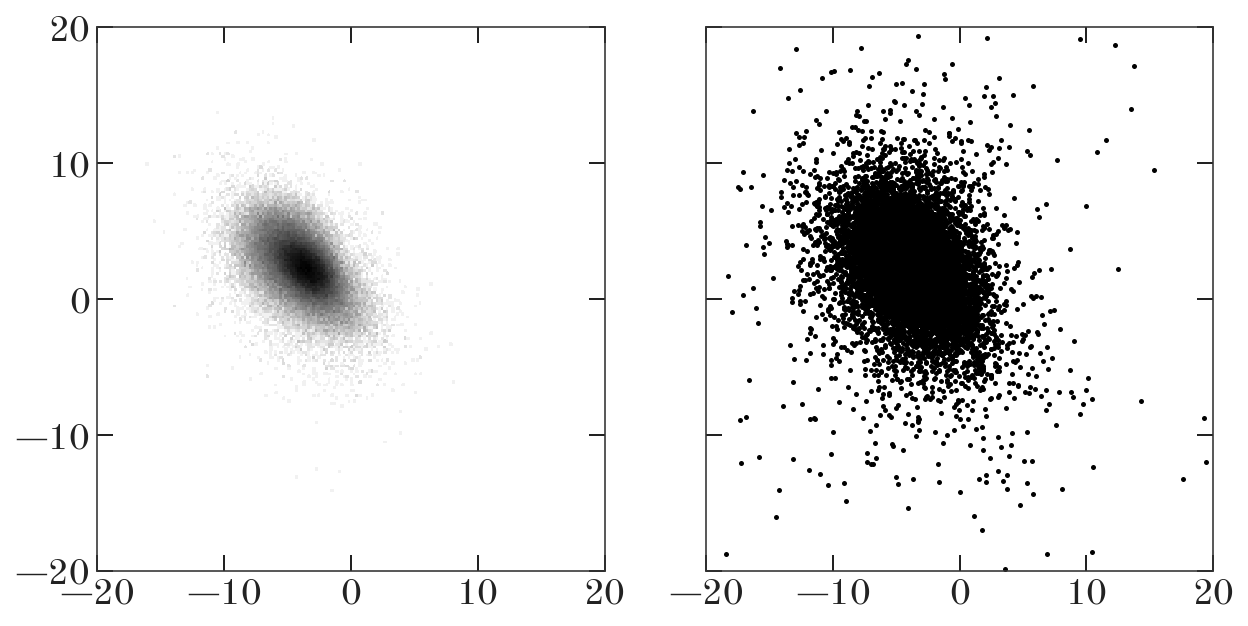

In [47]:
test = gmm.sample(size=100000)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True)

ax = axes[0]
H_test, xe, ye = np.histogram2d(test[:, 0], test[:, 1], bins=np.arange(-20, 20+1e-3, 0.2))
ax.pcolormesh(xe, ye, H_test.T, norm=mpl.colors.LogNorm(), cmap='Greys')

ax = axes[1]
ax.plot(X_co[:, 0], X_co[:, 1], marker='.', ls='none', alpha=1)
# ax.plot(X_cl[:, 0], X_cl[:, 1], marker='.', ls='none', alpha=1)

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

In [18]:
def ln_normal(x, mu, var):
    return -0.5*np.log(2*np.pi) - 0.5*np.log(var) - 0.5 * (x-mu)**2 / var

def ln_prior(p):
    x, y, lns, lnf = p
    
    lp = 0
    
    if x < -5 or x > 5 or y < -5 or y > 5:
        return -np.inf
    
    lp += ln_normal(lns, -1, 5)
    lp += -lnf
    
    return lp

def ln_likelihood(p, gmm, X, Cov):
    x, y, lns, lnf = p
    s = np.exp(lns)
    f = np.exp(lnf)
    
    mu = np.array([[x, y]])
    V = np.array([[[s, 0],
                   [0, s]]]) ** 2
    
    T = Cov + V
    logproba = log_multivariate_gaussian(X, mu, T)
    
    ll1 = bg_prob + np.log(1-f)
    ll2 = logproba + np.log(f)
    
    return np.logaddexp(ll1, ll2).sum(), (ll1, ll2)

def ln_posterior(p, *args):
    lnp = ln_prior(p)
    if not np.isfinite(lnp):
        return -np.inf #, None

    lnl, blob = ln_likelihood(p, *args)
    if not np.isfinite(lnl):
        return -np.inf # , None

    return lnp + lnl# , blob

In [19]:
faster_gmm = XDGMM(n_components=gmm.n_components, 
                   mu=gmm.mu, V=gmm.V, weights=gmm.weights, 
                   method='astroML')

In [20]:
bg_prob = logsumexp(faster_gmm.logprob_a(X_cl, Cov_cl), axis=-1)

In [22]:
# %%time
# ln_posterior(p0, faster_gmm, X_cl, Cov_cl)

In [23]:
p0 = (-0.095, 0.058, np.log(0.2), np.log(0.1))
res = minimize(lambda *args, **kwargs: -ln_likelihood(*args, **kwargs)[0],
               x0=p0, args=(faster_gmm, X_cl, Cov_cl), method='L-BFGS-B')
print('done optimize', res)

done optimize       fun: 57451.75425189284
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.6177288 , -0.67229848,  0.        ,  0.12805685])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 135
      nit: 22
   status: 0
  success: True
        x: array([-0.06591323,  0.03063623, -6.77801172, -3.16756401])


In [24]:
%%time
ln_likelihood(p0, faster_gmm, X_cl, Cov_cl)

CPU times: user 501 ms, sys: 3.59 ms, total: 504 ms
Wall time: 501 ms


(-57622.70757825786,
 (array([-4.16066495, -4.70916868, -4.13353491, ..., -7.13098023,
         -7.02926302, -4.81564927]),
  array([  -5.6122533 ,   -7.61596891,  -53.29147355, ...,   -7.20203029,
          -14.14086925, -102.80039744])))

In [25]:
%load_ext line_profiler

In [26]:
%lprun -f ln_likelihood ln_likelihood(p0, faster_gmm, X_cl, Cov_cl)

In [27]:
from schwimmbad import MultiPool

In [29]:
nwalkers = 32
# pp0 = p0
pp0 = res.x
all_p0 = emcee.utils.sample_ball(pp0, [1e-3]*len(pp0), size=nwalkers)

with MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, len(pp0), ln_posterior,
                                    args=(faster_gmm, X_cl, Cov_cl),
                                    pool=pool)
    pos, *_ = sampler.run_mcmc(all_p0, 128, progress=True)
    sampler.reset()
    pos, *_ = sampler.run_mcmc(pos, 128, progress=True)
    
# print('done burn-in')
# sampler.reset()
# pos, prob, state, blobs = sampler.run_mcmc(pos, 256, progress=True)

100%|██████████| 128/128 [03:50<00:00,  1.80s/it]


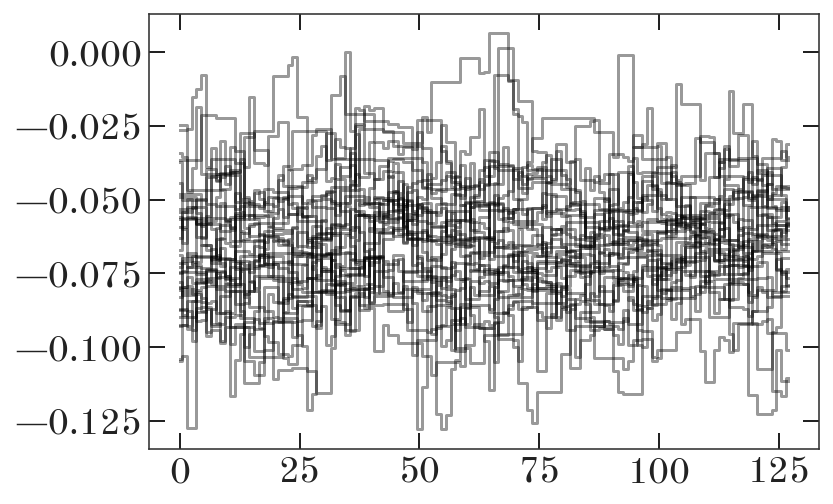

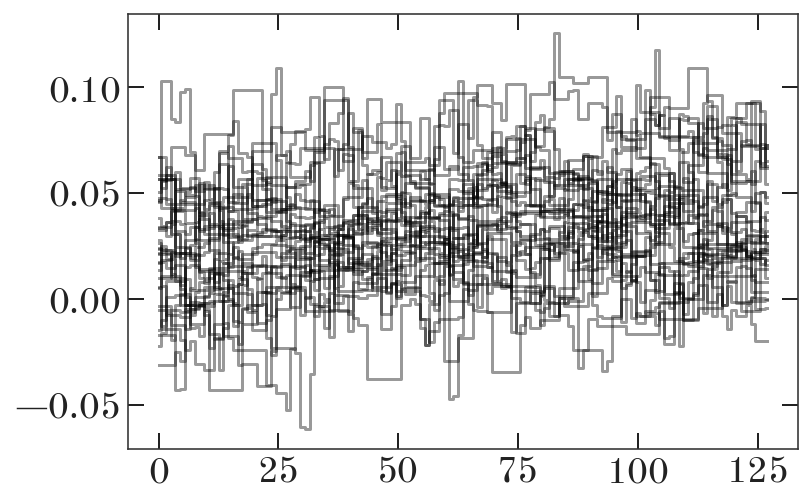

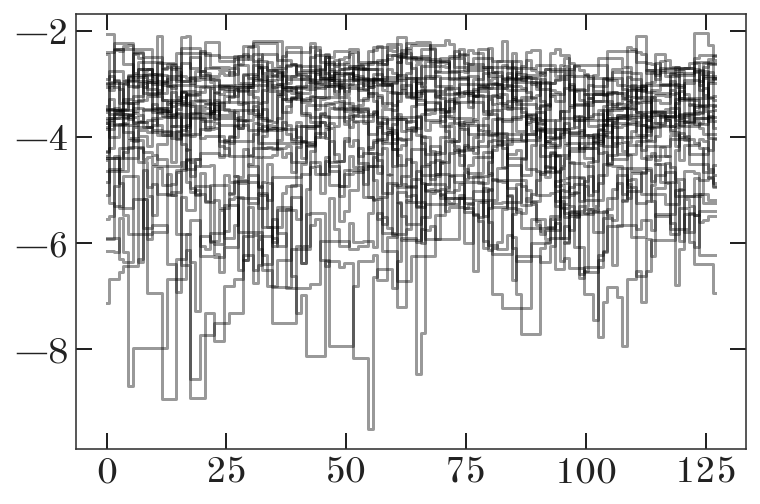

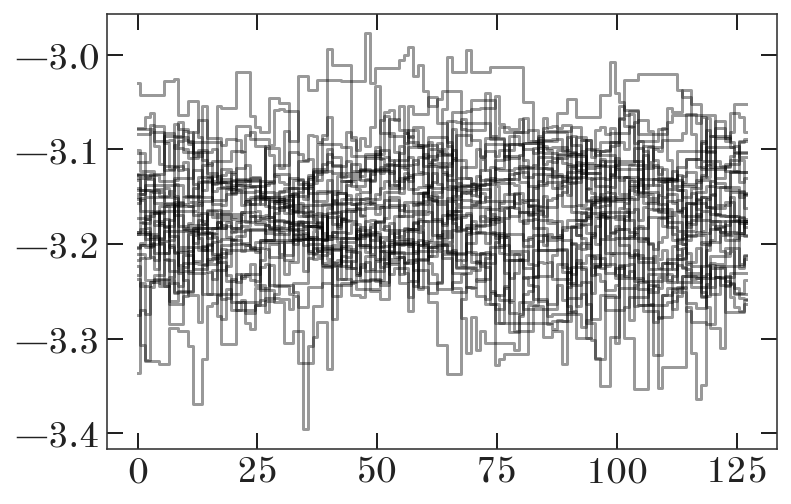

In [30]:
for k in range(sampler.chain.shape[-1]):
    plt.figure()
    for walker in sampler.chain[..., k]:
        plt.plot(walker, drawstyle='steps-mid', marker='', alpha=0.4, color='k')

In [31]:
flatchain = np.vstack(sampler.chain[:, 64:])

In [32]:
np.mean(flatchain, axis=0)

array([-0.06455768,  0.03731158, -3.97812492, -3.16743937])

In [33]:
np.std(flatchain, axis=0)

array([0.01898946, 0.02767748, 1.10764868, 0.06544964])